In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import decoupler as dc
import seaborn as sns
import gseapy as gp
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib
import scipy as sp
from plot_lib import *

In [2]:
#Okabe- Ito palette
pal = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F5C710", "#0072B2", "#D55E00", "#CC79A7", "#999999"]

# define top and bottom colormaps 
top = plt.get_cmap('Oranges_r', 128) # r means reversed version
bottom = plt.get_cmap('Blues', 128)# combine it all
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))# create a new colormaps with a name of OrangeBlue
orange_blue = colors.ListedColormap(newcolors, name='OrangeBlue')

In [3]:
color_pal = {}
for x in zip(["CollecTri", "M2Kb_K-562", "M2Kb_MCF-7", "M2Kb_HepG2", "M2Kb_GM-12878", "CA_K-562", "CA_MCF-7", "CA_HepG2", "CA_GM-12878"], 
             [pal[7], pal[2], pal[3], pal[4], pal[8], pal[1], pal[0], pal[5], pal[6]]):
    color_pal[x[0]] = colors.to_rgba(x[1])
    
cmap = matplotlib.colors.ListedColormap([pal[7], pal[2], pal[3], pal[4], pal[8], pal[1], pal[0], pal[5], pal[6]])
net_dict = {"CollecTri": 7, 
            "M2Kb_K-562": 2, 
            "M2Kb_MCF-7": 3, 
            "M2Kb_HepG2": 4, 
            "M2Kb_GM-12878": 8,
            "CA_K-562": 1,
            "CA_MCF-7": 0,
            "CA_HepG2": 5,
            "CA_GM-12878": 6}

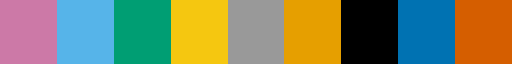

In [4]:
cmap

Network data loading

In [5]:
collectri = dc.get_collectri(organism='human', split_complexes=False)

In [6]:
chip_atlas_mcf7 = pd.read_table("../data/regulons/ChIP-Atlas_target_genes_MCF7.tsv", sep="\t")

In [7]:
mcf7 = pd.read_table("../data/regulons/TF_target_mapping_filtered_merged_MCF7_with_ppi_with_dnase_with_atac_with_motifs_with_ccres_cleaned.tsv", sep="\t")

mcf7 = mcf7.loc[mcf7.is_M2Kb & (mcf7.is_pls | mcf7.is_pels | mcf7.is_dels), ["tf", "gene_symbol"]].drop_duplicates(["tf", "gene_symbol"])
mcf7 = mcf7.loc[mcf7.tf.isin(collectri.source) & mcf7.tf.isin(chip_atlas_mcf7.tf)]
mcf7.shape

(543778, 2)

In [8]:
chip_atlas_mcf7 = chip_atlas_mcf7.loc[chip_atlas_mcf7.tf.isin(mcf7.tf)]
chip_atlas_mcf7.shape

(2668214, 2)

In [9]:
collectri = collectri[collectri.source.isin(mcf7.tf)]

### Prepare cosmic

In [10]:
COSMIC = dc.get_resource('CancerGeneCensus')

COSMIC.tumour_types_somatic = COSMIC.tumour_types_somatic.str.split(";")

COSMIC = COSMIC.explode("tumour_types_somatic")
cosmic_dict = {}
for typ in COSMIC.tumour_types_somatic.drop_duplicates():
    if COSMIC.loc[COSMIC.tumour_types_somatic == typ].genesymbol.shape[0] > 1:
        cosmic_dict[typ] = COSMIC.loc[COSMIC.tumour_types_somatic == typ].genesymbol.to_list()

# BC dataset

In [11]:
adata_bc = sc.read_h5ad("../data/case_study/wu_et_al_brca.h5ad")

In [12]:
adata_bc.obs.Calls.value_counts()

Calls
no_scTYPER_call    75575
LumA_SC             7943
Basal_SC            6631
Her2_SC             5711
LumB_SC             4204
Name: count, dtype: int64

In [13]:
sc.pp.neighbors(adata_bc)
sc.tl.umap(adata_bc)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/marii/.conda/envs/chip_seq_reg/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.


In [14]:
adata_bc.obs.head()

,Patient,Percent_mito,nCount_RNA,nFeature_RNA,celltype_major,celltype_minor,celltype_subset,subtype,gene_module,Calls,normal_cell_call,CNA_value
CID3586_AAGACCTCAGCATGAG,CID3586,1.506221,4581,1689,Endothelial,Endothelial ACKR1,Endothelial ACKR1,HER2+,no_gene_module,no_scTYPER_call,no_inferCNV_call,no_CNA_value
CID3586_AAGGTTCGTAGTACCT,CID3586,5.793743,1726,779,Endothelial,Endothelial ACKR1,Endothelial ACKR1,HER2+,no_gene_module,no_scTYPER_call,no_inferCNV_call,no_CNA_value
CID3586_ACCAGTAGTTGTGGCC,CID3586,1.383238,1229,514,Endothelial,Endothelial ACKR1,Endothelial ACKR1,HER2+,no_gene_module,no_scTYPER_call,no_inferCNV_call,no_CNA_value
CID3586_ACCCACTAGATGTCGG,CID3586,1.923077,1352,609,Endothelial,Endothelial ACKR1,Endothelial ACKR1,HER2+,no_gene_module,no_scTYPER_call,no_inferCNV_call,no_CNA_value
CID3586_ACTGATGGTCAACTGT,CID3586,13.325541,1711,807,Endothelial,Endothelial ACKR1,Endothelial ACKR1,HER2+,no_gene_module,no_scTYPER_call,no_inferCNV_call,no_CNA_value


In [15]:
adata_bc_epi = adata_bc[adata_bc.obs.celltype_major.isin(["Cancer Epithelial", 'Normal Epithelial'])]

/home/marii/.local/lib/python3.10/site-packages/scanpy/plotting/_utils.py:431: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
/home/marii/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
/home/marii/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/home/marii/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avo

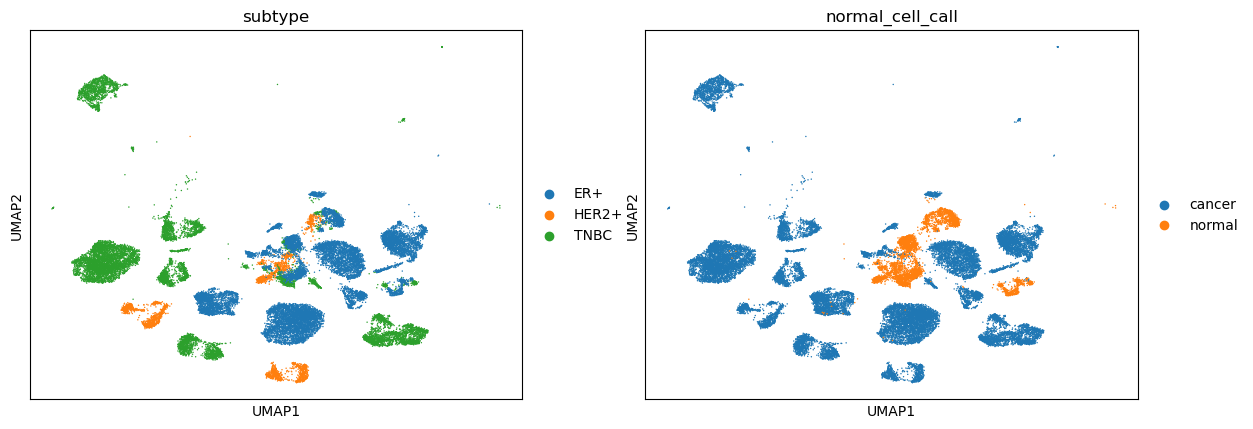

In [16]:
sc.pl.umap(adata_bc_epi, color=["subtype", "normal_cell_call"])

/home/marii/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
/home/marii/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/home/marii/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
/home/marii/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters

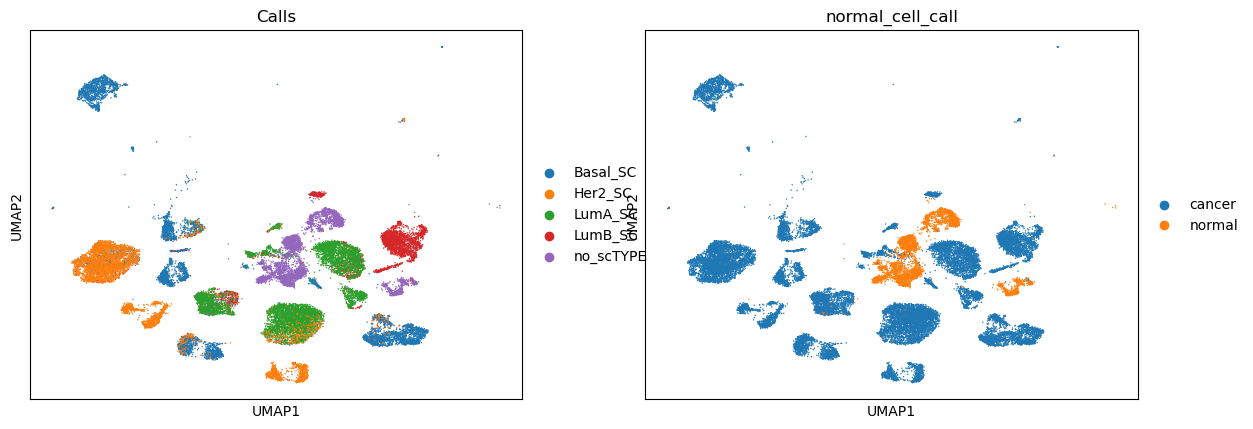

In [17]:
sc.pl.umap(adata_bc_epi, color=["Calls", "normal_cell_call"])

/home/marii/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
/home/marii/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


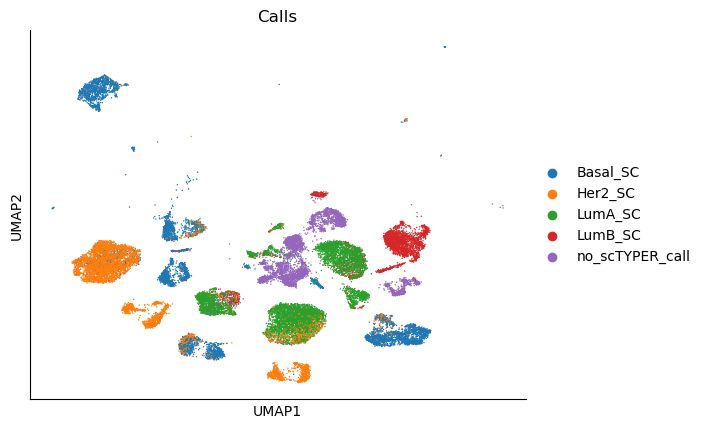

In [18]:
fig, ax = plt.subplots()

right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)

sc.pl.umap(adata_bc_epi, color="Calls", ax=ax)

In [19]:
adata_bc_epi.obs.Calls.value_counts()

Calls
LumA_SC            7943
Basal_SC           6631
Her2_SC            5711
no_scTYPER_call    4355
LumB_SC            4204
Name: count, dtype: int64

In [20]:
sc.tl.rank_genes_groups(adata_bc_epi, groupby='Calls', method='wilcoxon', use_raw=False, reference='no_scTYPER_call')

/home/marii/.conda/envs/chip_seq_reg/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
/home/marii/.conda/envs/chip_seq_reg/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
/home/marii/.conda/envs/chip_seq_reg/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
/home/marii/.conda/envs/chip_seq_reg/lib/python3.10/site-packages/numpy/core/fromn

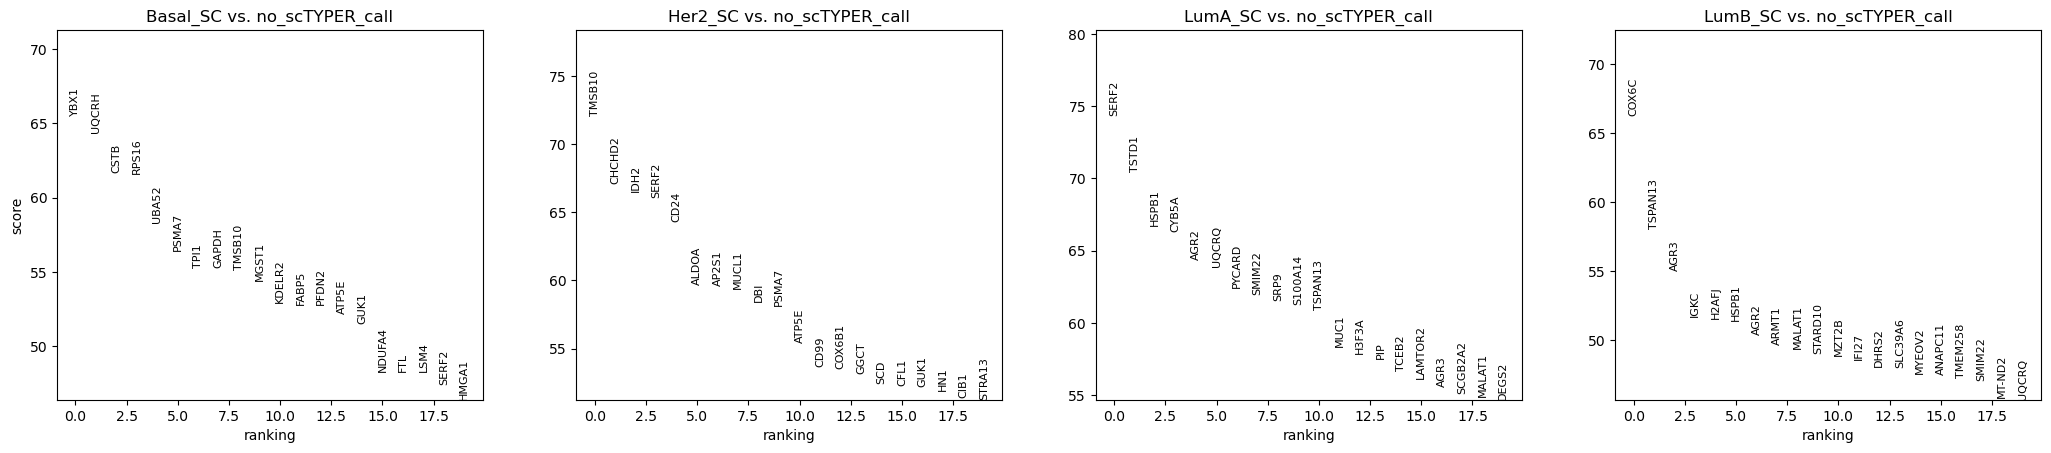

In [21]:
sc.pl.rank_genes_groups(adata_bc_epi, sharey=False)#, gene_symbols="feature_name")

## Basal cells

In [22]:
bas_disreg_enrich = pd.DataFrame()
bas_omim_enrich = pd.DataFrame()
bas_cosmic_enrich = pd.DataFrame()
megaheat = pd.DataFrame()

In [23]:
de_genes = sc.get.rank_genes_groups_df(adata_bc_epi, group=None,  pval_cutoff=1e-2)

de_genes = de_genes[de_genes.group == "Basal_SC"]

de_genes.index = pd.MultiIndex.from_frame(de_genes[["names", "group"]])
de_genes

de_genes = de_genes["logfoldchanges"].unstack(level=1).T
de_genes.head()

de_genes = de_genes.loc[:, ~de_genes.T.Basal_SC.isna().T]

In [24]:
enr = gp.enrich(de_genes.loc[:, (de_genes.T.Basal_SC.abs() > 1).T].columns.to_list(), "DisGeNET")

enr.results

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,DisGeNET,Mammary Neoplasms,627/2387,4.472380e-37,3.971920e-33,0,0,1.959967,164.044766,CDA;SERPINE2;SERPINE1;ENO1;ALKBH8;MYLK;PREX1;G...
1,DisGeNET,Breast Carcinoma,1114/4963,1.146474e-34,5.090916e-31,0,0,1.669213,130.451026,C4BPA;ALKBH8;MYLK;PREX1;NDST1;PSMD4;TDO2;ZC3H1...
2,DisGeNET,Malignant neoplasm of breast,1117/5054,1.113718e-31,3.296978e-28,0,0,1.627258,115.978660,POP1;ACCS;ALKBH8;MYLK;PREX1;NDST1;PSMD4;TDO2;Z...
3,DisGeNET,Neoplasm Metastasis,900/3920,3.026663e-30,6.719950e-27,0,0,1.669168,113.453488,ACCS;MYLK;PREX1;ZEB1-AS1;PSMD4;TDO2;PSMD2;ZC3H...
4,DisGeNET,Carcinogenesis,925/4065,9.539012e-30,1.694319e-26,0,0,1.652418,110.418175,C4BPA;PREX1;ZEB1-AS1;PSMD4;ZC3H12A;CKMT1B;WLS;...
...,...,...,...,...,...,...,...,...,...,...
8876,DisGeNET,Neuronal Ceroid-Lipofuscinoses,1/39,9.991920e-01,9.994409e-01,0,0,0.131192,0.000106,CTSF
8877,DisGeNET,Orbital separation diminished,1/39,9.991920e-01,9.994409e-01,0,0,0.131192,0.000106,GJA1
8878,DisGeNET,Congenital Bilateral Cataracts,4/75,9.992476e-01,9.994409e-01,0,0,0.280557,0.000211,CAV1;SORD;SDHD;EPHA2
8879,DisGeNET,Night Blindness,10/132,9.993283e-01,9.994409e-01,0,0,0.407667,0.000274,SEMA4A;ADGRV1;FAM161A;IMPDH1;MAK;FLVCR1;RP9;RE...


CollecTri

In [25]:
tf_acts_ctri, tf_pvals_ctri = dc.run_ulm(de_genes, collectri, weight=None)

In [26]:
mask_ctri = tf_pvals_ctri < 0.05

active_tfs_ctri = tf_acts_ctri.loc[:, pd.DataFrame(tf_acts_ctri * mask_ctri).sum(axis=0) != 0].columns.to_list()

In [27]:
tf_acts_ctri.index = ["score"]
tf_pvals_ctri.index = ["p_value"]
out_ctri = pd.merge(left=tf_acts_ctri.T, right=tf_pvals_ctri.T, left_index=True, right_index=True)
out_ctri.to_csv("../data/3-tf_activity/bc_bas_activity_collectri.tsv", sep="\t", index=False)

In [28]:
enr = gp.enrich(active_tfs_ctri, "OMIM_Expanded")
enr.results["Network"] = "CollecTri"
enr.results.to_csv("../data/3-tf_disease_enrichment/bc_omim_enrich_collectri_bas.tsv", sep="\t", index=False)
bas_omim_enrich = pd.concat([bas_omim_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [29]:
enr = gp.enrich(active_tfs_ctri, "DisGeNET")
enr.results["Network"] = "CollecTri"
enr.results.to_csv("../data/3-tf_disease_enrichment/bc_disgenet_enrich_collectri_bas.tsv", sep="\t", index=False)
bas_disreg_enrich = pd.concat([bas_disreg_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [30]:
try:
    enr = gp.enrich(gene_list=active_tfs_ctri, gene_sets=cosmic_dict, background=None)
    enr.results["Network"] = "CollecTri"
    enr.results.to_csv("../data/3-tf_disease_enrichment/bc_cosmic_enrich_collectri_bas.tsv", sep="\t", index=False)
    bas_cosmic_enrich = pd.concat([bas_cosmic_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)
except ValueError:
    enr.results["Network"] = "CollecTri"
    bas_cosmic_enrich = pd.concat([bas_cosmic_enrich, pd.DataFrame()], axis=0)

In [31]:
heat = pd.concat([tf_acts_ctri.rename({"Basal_SC": "score"}), tf_pvals_ctri.rename({"Basal_SC": "p_value"})], axis=0).T
#heat = heat.reindex(heat.abs().sort_values("leukemic", ascending=False).index).head(5)
heat["Network"] = "CollecTri"
#heat["TFs"] = heat.index
megaheat = pd.concat([megaheat, heat], axis =0)
megaheat.describe()

,score,p_value
count,96.000000,9.600000e+01
mean,-0.619625,2.764471e-01
std,1.888077,2.825133e-01
min,-4.942216,3.705592e-11
25%,-1.824978,3.035262e-02
50%,-0.760529,1.268689e-01
75%,0.357879,5.095636e-01
max,6.624145,9.324165e-01


MCF7

In [32]:
tf_acts_mcf7, tf_pvals_mcf7 = dc.run_ulm(de_genes, mcf7, source='tf', target='gene_symbol', weight=None)

In [33]:
mask_mcf7 = tf_pvals_mcf7 < 0.05

active_tfs_mcf7 = tf_acts_mcf7.loc[:, pd.DataFrame(tf_acts_mcf7 * mask_mcf7).sum(axis=0) != 0].columns.to_list()

In [34]:
tf_acts_mcf7.index = ["score"]
tf_pvals_mcf7.index = ["p_value"]
out_mcf7 = pd.merge(left=tf_acts_mcf7.T, right=tf_pvals_mcf7.T, left_index=True, right_index=True)
out_mcf7.to_csv("../data/3-tf_activity/bc_bas_activity_m2kb.tsv", sep="\t", index=False)

In [35]:
enr = gp.enrich(active_tfs_mcf7, "OMIM_Expanded")
enr.results["Network"] = "M2Kb_MCF-7"
enr.results.to_csv("../data/3-tf_disease_enrichment/bc_omim_enrich_m2kb_mcf7_bas.tsv", sep="\t", index=False)
bas_omim_enrich = pd.concat([bas_omim_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [36]:
enr = gp.enrich(active_tfs_mcf7, "DisGeNET")
enr.results["Network"] = "M2Kb_MCF-7"
enr.results.to_csv("../data/3-tf_disease_enrichment/bc_disgenet_enrich_m2kb_mcf7_bas.tsv", sep="\t", index=False)
bas_disreg_enrich = pd.concat([bas_disreg_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [37]:
try:
    enr = gp.enrich(gene_list=active_tfs_mcf7, gene_sets=cosmic_dict, background=None)
    enr.results["Network"] = "M2Kb_MCF-7"
    enr.results.to_csv("../data/3-tf_disease_enrichment/bc_cosmic_enrich_m2kb_mcf7_bas.tsv", sep="\t", index=False)
    bas_cosmic_enrich = pd.concat([bas_cosmic_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)
except ValueError:
    enr.results["Network"] = "M2Kb_MCF-7"
    bas_cosmic_enrich = pd.concat([bas_cosmic_enrich, pd.DataFrame()], axis=0)

In [38]:
heat = pd.concat([tf_acts_mcf7.rename({"Basal_SC": "score"}), tf_pvals_mcf7.rename({"Basal_SC": "p_value"})], axis=0).T
heat["Network"] = "M2Kb_MCF-7"
megaheat = pd.concat([megaheat, heat], axis =0)
megaheat

,score,p_value,Network
AHR,-1.790777,7.336471e-02,CollecTri
AR,-4.942216,7.872029e-07,CollecTri
ARID3A,1.807913,7.065547e-02,CollecTri
ARNT,-1.557487,1.193924e-01,CollecTri
ATF7,-1.570417,1.163555e-01,CollecTri
...,...,...,...
ZNF217,-2.395973,1.659788e-02,M2Kb_MCF-7
ZNF24,-2.753978,5.900134e-03,M2Kb_MCF-7
ZNF444,-4.168815,3.092354e-05,M2Kb_MCF-7
ZNF512B,-3.174494,1.506353e-03,M2Kb_MCF-7


chip_atlas_mcf7

In [39]:
tf_acts_chip_atlas_mcf7, tf_pvals_chip_atlas_mcf7 = dc.run_ulm(de_genes, chip_atlas_mcf7.drop_duplicates(), source='tf', target='Target_genes', weight=None)

In [40]:
mask_chip_atlas_mcf7 = tf_pvals_chip_atlas_mcf7 < 0.05

active_tfs_chip_atlas_mcf7 = tf_acts_chip_atlas_mcf7.loc["Basal_SC", pd.DataFrame(tf_acts_chip_atlas_mcf7 * mask_chip_atlas_mcf7).sum(axis=0) != 0].index.to_list()
tf_acts_chip_atlas_mcf7.loc["Basal_SC", pd.DataFrame(tf_acts_chip_atlas_mcf7 * mask_chip_atlas_mcf7).sum(axis=0) != 0]

AHR      -4.016224
AR       -3.903622
ARID1A   -6.377027
ARID1B   -4.682735
ARNT     -3.199601
            ...   
TP53     -3.074068
TRPS1    -4.109886
YAP1     -3.847417
ZFX      -3.890908
ZNF143   -4.901317
Name: Basal_SC, Length: 75, dtype: float32

In [41]:
tf_acts_chip_atlas_mcf7.index = ["score"]
tf_pvals_chip_atlas_mcf7.index = ["p_value"]
out_chip_atlas_mcf7 = pd.merge(left=tf_acts_chip_atlas_mcf7.T, right=tf_pvals_chip_atlas_mcf7.T, left_index=True, right_index=True)
out_chip_atlas_mcf7.to_csv("../data/3-tf_activity/bc_bas_activity_ca_mcf7.tsv", sep="\t", index=False)

In [42]:
try:    
    enr = gp.enrich(active_tfs_chip_atlas_mcf7, "OMIM_Expanded")
    enr.results["Network"] = "CA_MCF-7"
    enr.results.to_csv("../data/3-tf_disease_enrichment/bc_omim_enrich_ca_mcf7_bas.tsv", sep="\t", index=False)
    bas_omim_enrich = pd.concat([bas_omim_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)
except:
    enr.results["Network"] = "CA_MCF-7"
    bas_omim_enrich = pd.concat([bas_omim_enrich, pd.DataFrame()], axis=0)

In [43]:
try:    
    enr = gp.enrich(active_tfs_chip_atlas_mcf7, "DisGeNET")
    enr.results["Network"] = "CA_MCF-7"
    enr.results.to_csv("../data/3-tf_disease_enrichment/bc_disgenet_enrich_ca_mcf7_bas.tsv", sep="\t", index=False)
    bas_disreg_enrich = pd.concat([bas_disreg_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)
except:
    enr.results["Network"] = "CA_MCF-7"
    bas_disreg_enrich = pd.concat([bas_disreg_enrich, pd.DataFrame()], axis=0)

In [44]:
try:
    enr = gp.enrich(gene_list=active_tfs_chip_atlas_mcf7, gene_sets=cosmic_dict, background=None)
    enr.results["Network"] = "CA_MCF-7"
    enr.results.to_csv("../data/3-tf_disease_enrichment/bc_cosmic_enrich_ca_mcf7_bas.tsv", sep="\t", index=False)
    bas_cosmic_enrich = pd.concat([bas_cosmic_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)
except ValueError:
    enr.results["Network"] = "CA_MCF-7"
    bas_cosmic_enrich = pd.concat([bas_cosmic_enrich, pd.DataFrame()], axis=0)

In [45]:
heat = pd.concat([tf_acts_chip_atlas_mcf7.rename({"Basal_SC": "score"}), tf_pvals_chip_atlas_mcf7.rename({"Basal_SC": "p_value"})], axis=0).T
heat["Network"] = "CA_MCF-7"
megaheat = pd.concat([megaheat, heat], axis =0)
megaheat

,score,p_value,Network
AHR,-1.790777,7.336471e-02,CollecTri
AR,-4.942216,7.872029e-07,CollecTri
ARID3A,1.807913,7.065547e-02,CollecTri
ARNT,-1.557487,1.193924e-01,CollecTri
ATF7,-1.570417,1.163555e-01,CollecTri
...,...,...,...
ZNF217,-0.722520,4.699946e-01,CA_MCF-7
ZNF24,0.206623,8.363093e-01,CA_MCF-7
ZNF444,-1.915276,5.549100e-02,CA_MCF-7
ZNF512B,-0.291218,7.708915e-01,CA_MCF-7


Plotting results

In [46]:
okabe = [pal[0], pal[7], pal[3]]

/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 30.000000000000004 x 150.0 mm image.
/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../plots/3-tf_disease_enrichment/bc_go_enrich_omim_bas.svg


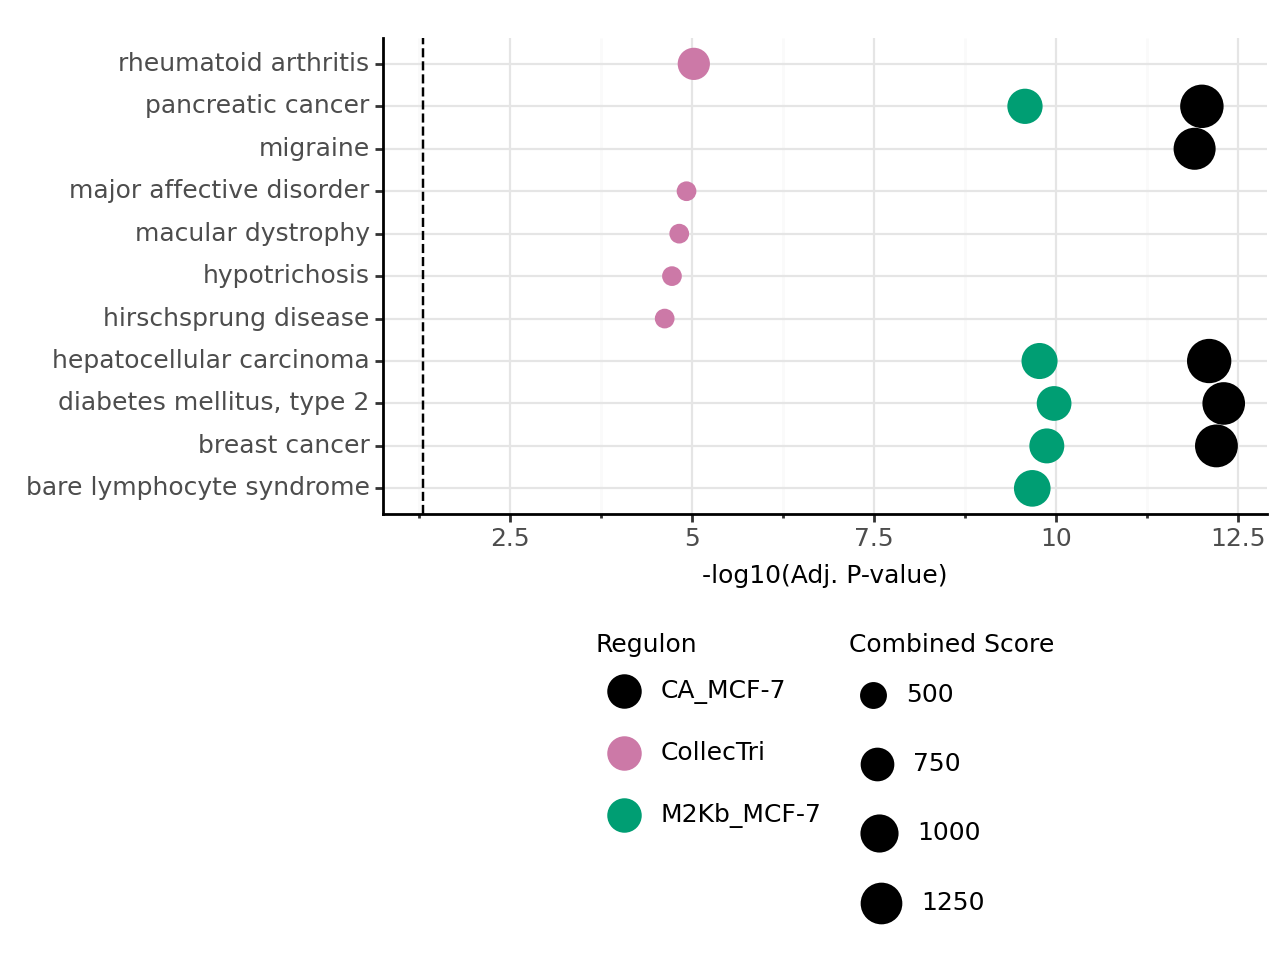

<Figure Size: (640 x 480)>

In [47]:
bas_omim_enrich["-log10(Adj. P-value)"] = - np.log10(bas_omim_enrich["Adjusted P-value"])
bas_omim_enrich = bas_omim_enrich.loc[bas_omim_enrich["Adjusted P-value"] < 0.05]
bas_omim_enrich.describe()

p = plot_enrich(bas_omim_enrich, okabe)
ggsave(p, "../plots/3-tf_disease_enrichment/bc_go_enrich_omim_bas.svg", width = 30, height = 150, units = "mm", dpi=720)
p

/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 30.000000000000004 x 150.0 mm image.
/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../plots/3-tf_disease_enrichment/bc_go_enrich_disreg_bas.svg


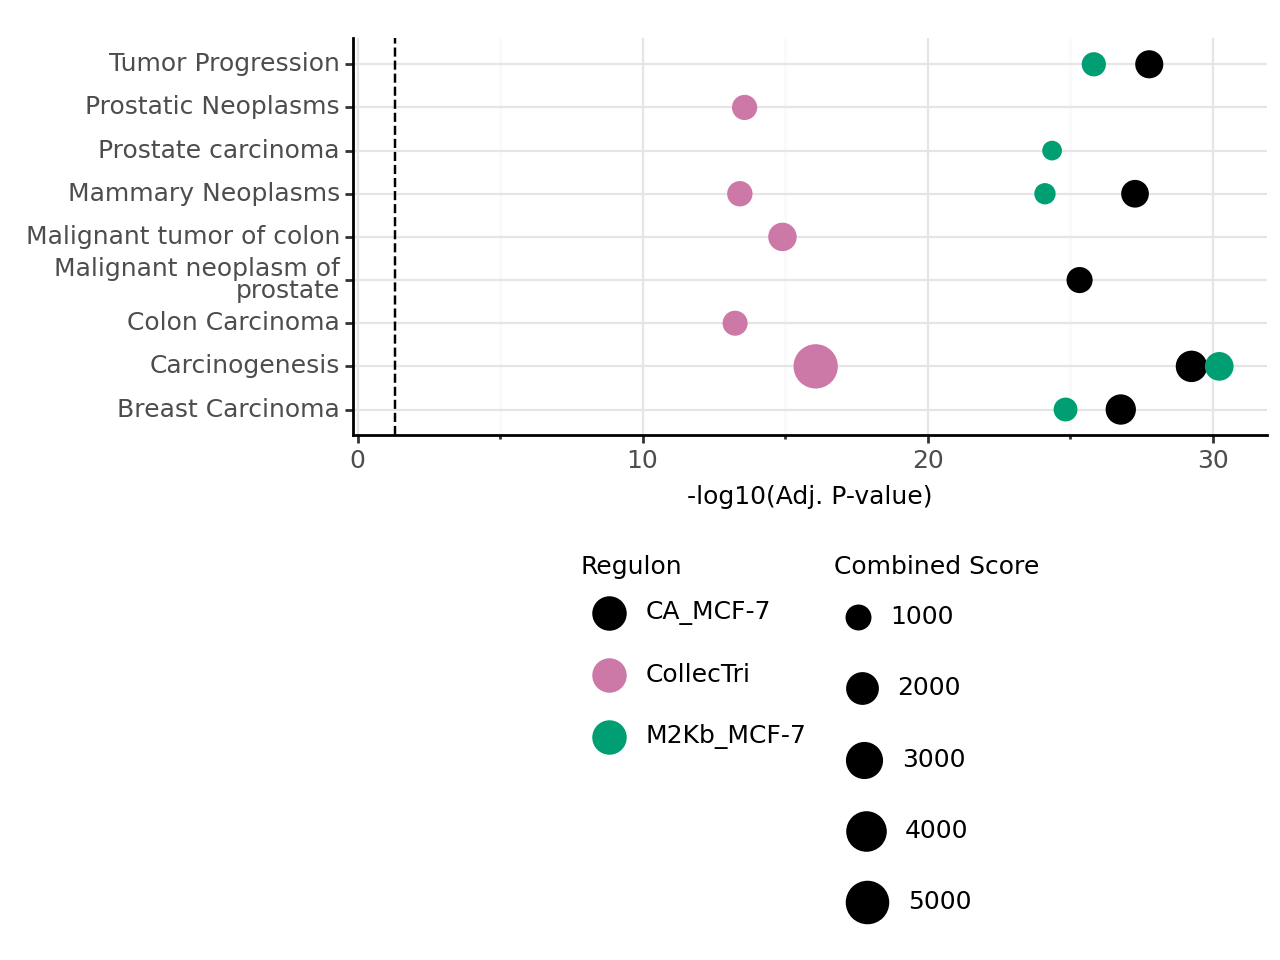

<Figure Size: (640 x 480)>

In [48]:
bas_disreg_enrich["-log10(Adj. P-value)"] = - np.log10(bas_disreg_enrich["Adjusted P-value"])
bas_disreg_enrich = bas_disreg_enrich.loc[bas_disreg_enrich["Adjusted P-value"] < 0.05]
bas_disreg_enrich.describe()

p = plot_enrich(bas_disreg_enrich, okabe)
ggsave(p, "../plots/3-tf_disease_enrichment/bc_go_enrich_disreg_bas.svg", width = 30, height = 150, units = "mm", dpi=720)
p

/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 50.0 x 150.0 mm image.
/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../plots/3-tf_disease_enrichment/bc_go_enrich_cosmic_bas.svg


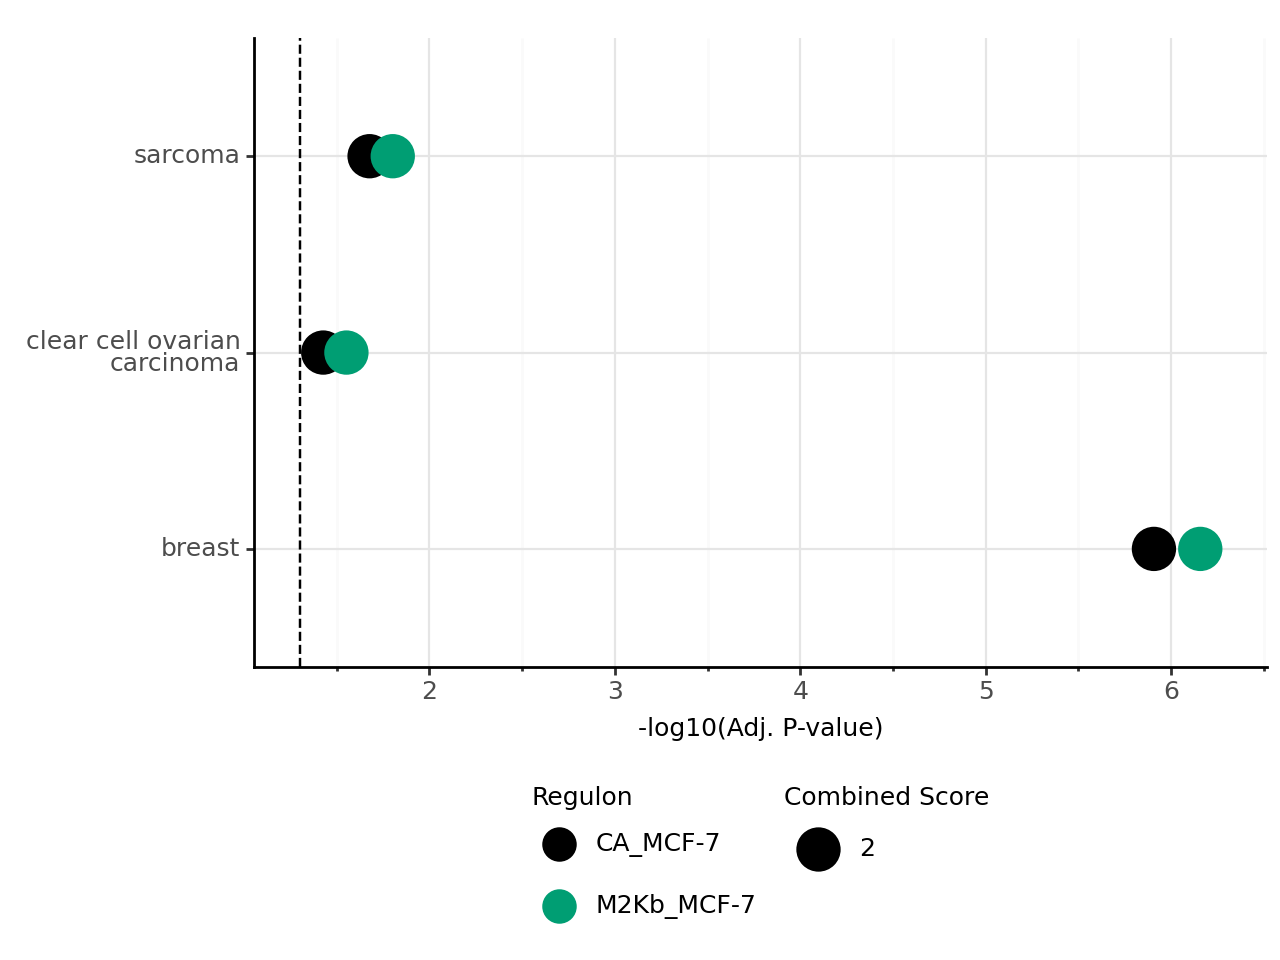

<Figure Size: (640 x 480)>

In [49]:
bas_cosmic_enrich["-log10(Adj. P-value)"] = - np.log10(bas_cosmic_enrich["Adjusted P-value"])
bas_cosmic_enrich = bas_cosmic_enrich.loc[bas_cosmic_enrich["Adjusted P-value"] < 0.05]
bas_cosmic_enrich.describe()

temp_pal = [okabe[0], okabe[2]]
p = plot_enrich(bas_cosmic_enrich, temp_pal, size=2)
ggsave(p, "../plots/3-tf_disease_enrichment/bc_go_enrich_cosmic_bas.svg", width=50, height=150, units = "mm", dpi=720)
p

In [50]:
bas_cosmic_enrich

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes,Network,-log10(Adj. P-value)
11,gs_ind_0,breast,9/24,1.873433e-08,5.807642e-07,16.272343,289.532313,FOXA1;ARID1B;ARID1A;ESR1;RB1;TP53;GATA3;CTCF;E...,M2Kb_MCF-7,6.236000
28,gs_ind_0,sarcoma,3/6,7.868243e-04,1.219578e-02,16.455910,117.618707,RB1;TP53;JUN,M2Kb_MCF-7,1.913791
12,gs_ind_0,clear cell ovarian carcinoma,2/3,3.721907e-03,3.845970e-02,20.913621,116.980741,ARID1B;ARID1A,M2Kb_MCF-7,1.414994
12,gs_ind_0,breast,9/24,4.479215e-08,1.478141e-06,14.299938,241.972583,FOXA1;ARID1B;ARID1A;ESR1;RB1;TP53;GATA3;CTCF;E...,CA_MCF-7,5.830284
30,gs_ind_0,sarcoma,3/6,1.014396e-03,1.673753e-02,14.993162,103.354799,RB1;TP53;JUN,CA_MCF-7,1.776309
13,gs_ind_0,clear cell ovarian carcinoma,2/3,4.403776e-03,4.844153e-02,19.133739,103.806138,ARID1B;ARID1A,CA_MCF-7,1.314782


In [51]:
megaheat.to_csv("../data/3-tf_activity/bc_activity_estimates_bas.tsv", sep="\t", index=False)

In [52]:
megaheat

,score,p_value,Network
AHR,-1.790777,7.336471e-02,CollecTri
AR,-4.942216,7.872029e-07,CollecTri
ARID3A,1.807913,7.065547e-02,CollecTri
ARNT,-1.557487,1.193924e-01,CollecTri
ATF7,-1.570417,1.163555e-01,CollecTri
...,...,...,...
ZNF217,-0.722520,4.699946e-01,CA_MCF-7
ZNF24,0.206623,8.363093e-01,CA_MCF-7
ZNF444,-1.915276,5.549100e-02,CA_MCF-7
ZNF512B,-0.291218,7.708915e-01,CA_MCF-7


In [53]:
megaheat = megaheat[megaheat.p_value < 0.05].sort_values("score")
megaheat["TF"] = megaheat.index
megaheat["log_p"] = - np.log10(megaheat.p_value).round(0)

In [54]:
print(megaheat[megaheat.Network == "M2Kb_MCF-7"].sort_values("score").to_string())

            score       p_value     Network       TF  log_p
ARID1B  -6.585671  4.798053e-11  M2Kb_MCF-7   ARID1B   10.0
EP300   -6.563979  5.547000e-11  M2Kb_MCF-7    EP300   10.0
SMARCA4 -6.503954  8.266768e-11  M2Kb_MCF-7  SMARCA4   10.0
ESR1    -6.175816  6.885423e-10  M2Kb_MCF-7     ESR1    9.0
GATA3   -5.978420  2.344311e-09  M2Kb_MCF-7    GATA3    9.0
SMARCC1 -5.652525  1.632347e-08  M2Kb_MCF-7  SMARCC1    8.0
NR3C1   -5.369849  8.089134e-08  M2Kb_MCF-7    NR3C1    7.0
NR2F2   -5.232158  1.715536e-07  M2Kb_MCF-7    NR2F2    7.0
ARID1A  -5.168232  2.417110e-07  M2Kb_MCF-7   ARID1A    7.0
CTCF    -5.006463  5.655695e-07  M2Kb_MCF-7     CTCF    6.0
JUN     -4.915129  9.038907e-07  M2Kb_MCF-7      JUN    6.0
MSX2    -4.827400  1.407482e-06  M2Kb_MCF-7     MSX2    6.0
REST    -4.720185  2.394103e-06  M2Kb_MCF-7     REST    6.0
TAF1    -4.700289  2.638944e-06  M2Kb_MCF-7     TAF1    6.0
EGR1    -4.616048  3.968728e-06  M2Kb_MCF-7     EGR1    5.0
JUND    -4.558875  5.214993e-06  M2Kb_MC

In [55]:
megaheat.sort_values(["score"])

,score,p_value,Network,TF,log_p
ESR1,-7.317427,2.758520e-13,CA_MCF-7,ESR1,13.0
KDM5B,-7.262698,4.130448e-13,CA_MCF-7,KDM5B,12.0
EP300,-6.932015,4.452778e-12,CA_MCF-7,EP300,11.0
NCOA3,-6.593267,4.559955e-11,CA_MCF-7,NCOA3,10.0
ARID1B,-6.585671,4.798053e-11,M2Kb_MCF-7,ARID1B,10.0
...,...,...,...,...,...
E2F8,4.497422,6.969826e-06,M2Kb_MCF-7,E2F8,5.0
RB1,6.073056,1.309049e-09,CA_MCF-7,RB1,9.0
E2F4,6.624145,3.705592e-11,CollecTri,E2F4,10.0
E2F4,7.818486,5.987760e-15,M2Kb_MCF-7,E2F4,14.0


/crex/proj/lappalainen_lab1/users/marii/chip_seq_ann/case_studies/plot_lib.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
/crex/proj/lappalainen_lab1/users/marii/chip_seq_ann/case_studies/plot_lib.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


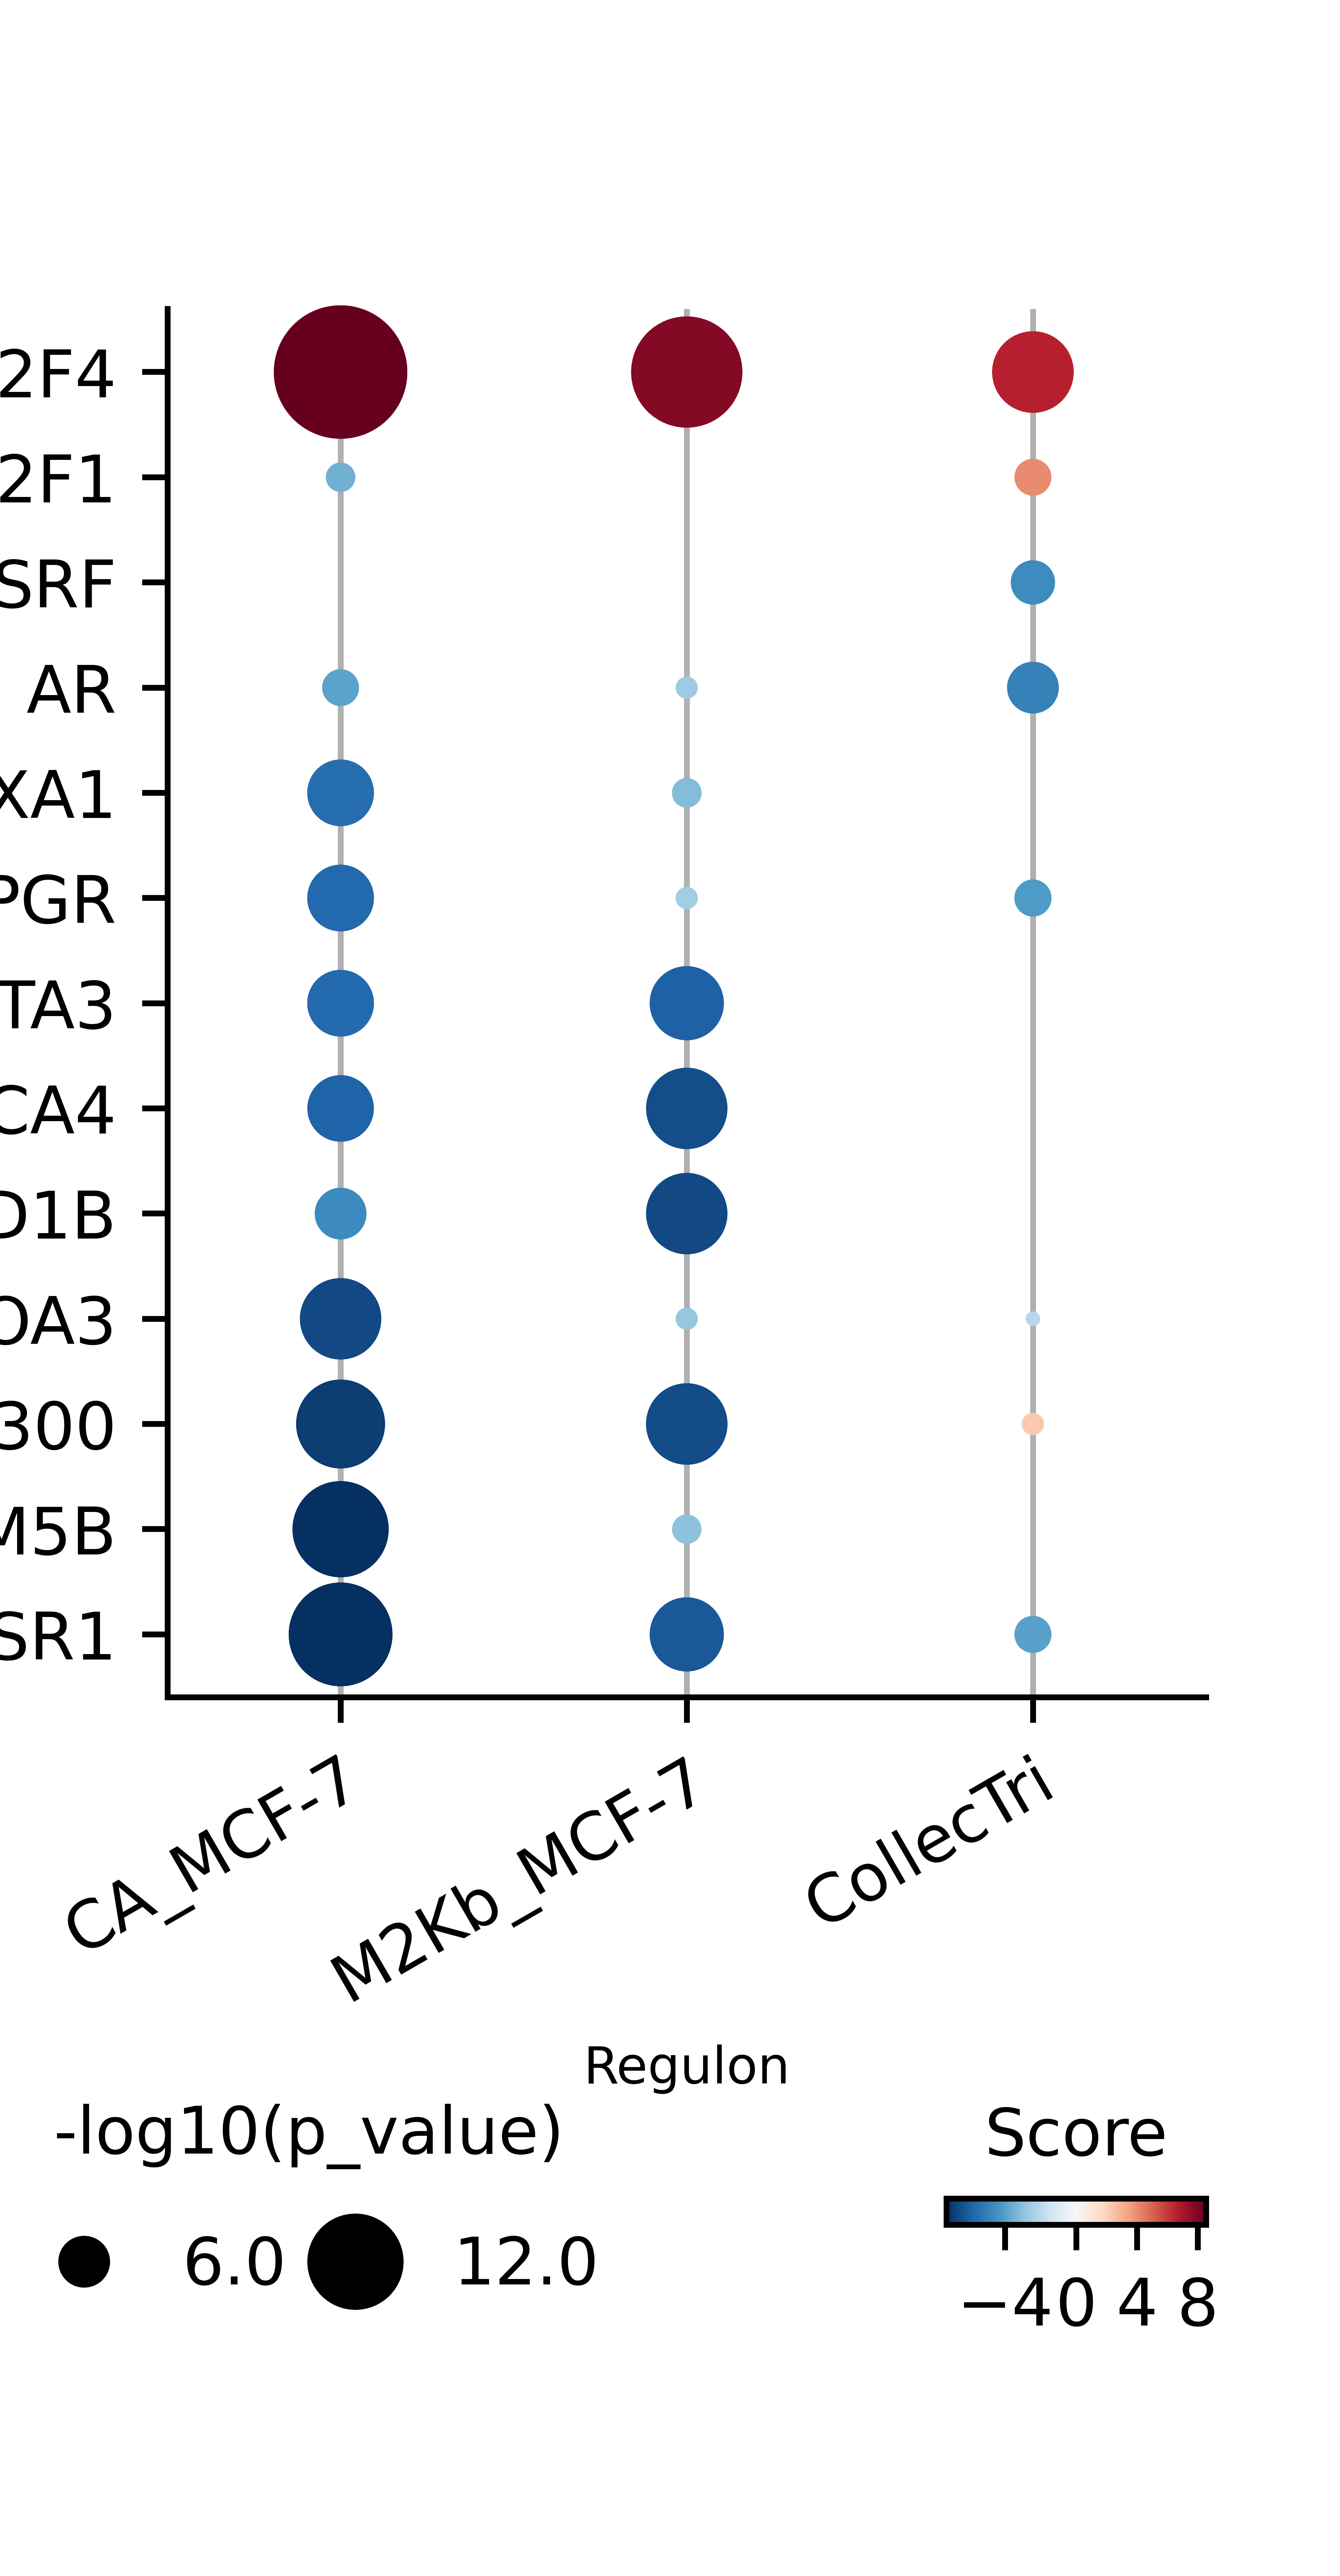

In [56]:
out = pd.DataFrame()
interesting_tf = ["ESR1", "PGR", "GATA3", "FOXA1"]
#interesting_tf = []
for net in ["M2Kb_MCF-7", "CollecTri", "CA_MCF-7"]:
    mask = megaheat[megaheat.Network == net].score.abs().sort_values(ascending=False).head(5).index
    out = pd.concat([out, megaheat.loc[megaheat.TF.isin(mask) | megaheat.TF.isin(interesting_tf), :]])
plot_bubbles(out[out.Network.isin(["CollecTri", "M2Kb_MCF-7", "CA_MCF-7"])], scale=0.17)
plt.savefig("../plots/3-tf_activity/bc_activity_clustermap_bas.svg", dpi=720, format="svg")

In [57]:
out

,score,p_value,Network,TF,log_p
ESR1,-7.317427,2.758520e-13,CA_MCF-7,ESR1,13.0
EP300,-6.932015,4.452778e-12,CA_MCF-7,EP300,11.0
ARID1B,-6.585671,4.798053e-11,M2Kb_MCF-7,ARID1B,10.0
EP300,-6.563979,5.547000e-11,M2Kb_MCF-7,EP300,10.0
SMARCA4,-6.503954,8.266768e-11,M2Kb_MCF-7,SMARCA4,10.0
ESR1,-6.175816,6.885423e-10,M2Kb_MCF-7,ESR1,9.0
GATA3,-5.978420,2.344311e-09,M2Kb_MCF-7,GATA3,9.0
SMARCA4,-5.920322,3.338227e-09,CA_MCF-7,SMARCA4,8.0
PGR,-5.743792,9.577758e-09,CA_MCF-7,PGR,8.0
GATA3,-5.662894,1.537022e-08,CA_MCF-7,GATA3,8.0
